### Importing Dependencies

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import keras

In [57]:
import pickle

def load_set(directory):
    try:
        with open(f"{directory}/texts.pkl", "rb") as fp:
            processed_texts = pickle.load(fp)
        
        with open(f"{directory}/labels.pkl", "rb") as fp:
            labels = pickle.load(fp)
    
    except:
        print(f'{directory} files not found. Please run the preprocess.ipynb before!')
    
    return processed_texts, labels

In [58]:
processed_texts, labels = load_set('train')
processed_val_texts, val_labels = load_set('val')
processed_test_texts, test_labels = load_set('test')

In [59]:
processed_texts[:5]

['need advice appreciate people will will super aggressive control 6 month ago cheat girlfriend tell shortly feel like shit remind come get bad want stay thought linger way closure come thank advance hope y’ hate',
 'dear Magic Eye Bot hate wanna T',
 'teacher sub right wrong answer assignment clearly personal choice',
 'officially close 30 year age 10 goodbye r teenager fun today reach age subreddit long target good thing care cause mind 12',
 'sure royal family racism thing interesting you hear conspiracy kidnap child own cult shit wild surprised queen live']

In [60]:
lengths = [len(processed_text) for processed_text in processed_texts if len(processed_text) < 2000]

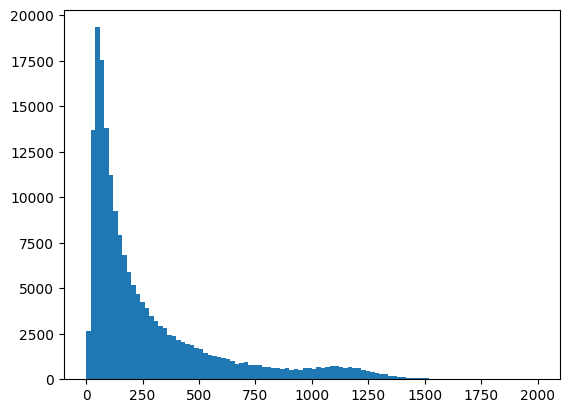

In [61]:
plt.hist(lengths, bins=100)
plt.show()

### Creating the Model

#### Vectorization

In [62]:
TextVectorization = keras.layers.TextVectorization

vectorize_layer = TextVectorization(
    max_tokens=3000,
    output_mode='int',
    output_sequence_length=200,
)

vectorize_layer.adapt(processed_texts + processed_val_texts)

In [63]:
vectorized_texts = vectorize_layer(processed_texts)

In [64]:
vectorized_val_texts = vectorize_layer(processed_val_texts)

#### Model 1

In [65]:
from keras_tuner import HyperParameters as hp
from keras_tuner import RandomSearch
Sequential = keras.models.Sequential

def build_model(hp):
    model = Sequential([
            keras.layers.Embedding(3000, 16),
        keras.layers.GRU(units = hp.Int('units', min_value=5, max_value=20, step=5), return_sequences=True),
        keras.layers.GRU(units = hp.Int('units', min_value=5, max_value=20, step=5)),
        keras.layers.Dense(1, activation = hp.Choice('activation', ['sigmoid', 'tanh', 'leaky_relu']))
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    return model

In [66]:
tuner = RandomSearch(
	build_model,
	objective='val_accuracy',
	max_trials=4,
	executions_per_trial=1,
	directory='../runs',
	project_name='gru_optimizer'
)

tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 20, 'step': 5, 'sampling': 'linear'}
activation (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid', 'tanh', 'leaky_relu'], 'ordered': False}


In [67]:
tuner.search(vectorized_texts, labels, epochs=5, validation_data=(vectorized_val_texts, val_labels), callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ])

Trial 4 Complete [00h 16m 18s]
val_accuracy: 0.9366166591644287

Best val_accuracy So Far: 0.9366166591644287
Total elapsed time: 01h 12m 32s


##### Evaluating the Model

In [68]:
vectorized_test_texts = vectorize_layer(processed_test_texts)

In [74]:
tuner.results_summary()
best_model = tuner.get_best_models(num_models=1)
best_model = best_model[0]
best_model.summary()

Results summary
Results in ../runs\gru_optimizer
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 3 summary
Hyperparameters:
units: 20
activation: tanh
Score: 0.9366166591644287

Trial 0 summary
Hyperparameters:
units: 20
activation: leaky_relu
Score: 0.935194730758667

Trial 1 summary
Hyperparameters:
units: 5
activation: tanh
Score: 0.929851770401001

Trial 2 summary
Hyperparameters:
units: 5
activation: leaky_relu
Score: 0.928343653678894


c:\Users\Qiuyu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:562: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 16)        │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 200, 20)        │         2,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 20)             │         2,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,821 (206.33 KB)

 Trainable params: 52,821 (206.33 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
_ = best_model.evaluate(vectorized_test_texts, test_labels)

726/726 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9371 - loss: 0.1727


In [71]:
y_pred = best_model.predict(vectorized_test_texts)
y_pred = (y_pred > 0.5).astype(int)
y_pred = np.array(list(map(lambda x: x[0], y_pred)))

726/726 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step


In [72]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()

fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr:.4f}")

fnr = fn / (fn + tp)
print(f"False Negative Rate: {fnr:.4f}")

print(f'accuracy_score {accuracy_score(test_labels, y_pred):.3f}')
print(f'precision_score {precision_score(test_labels, y_pred):.3f}')
print(f'recall_score {recall_score(test_labels, y_pred):.3f}')
print(f'f1_score {f1_score(test_labels, y_pred):.3f}')

False Positive Rate: 0.0531
False Negative Rate: 0.0731
accuracy_score 0.937
precision_score 0.945
recall_score 0.927
f1_score 0.936


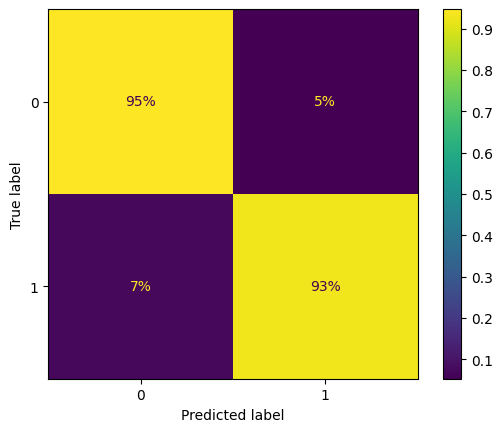

In [73]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_labels, y_pred, normalize="true",
                                        values_format=".0%")
plt.show()